## 1. 导入数据与预处理

In [3]:
# import data
library(tidyverse)
library(here)
library(janitor)

raw_data <- read_csv(here(
    "data", "input",
    "subdata_with_alpha_decay.csv"
))
glimpse(raw_data)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  Subject = col_character(),
  logfile_name = col_character(),
  condition = col_character(),
  factors = col_character(),
  rule = col_character()
)
ℹ Use `spec()` for the full column specifications.




Rows: 31,477
Columns: 30
$ X1             <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ stim_color     <dbl> 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1…
$ stim_loc       <dbl> 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1…
$ Type           <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ Response       <dbl> 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1…
$ RT             <dbl> 939.5, 682.6, 391.8, 404.8, 369.6, 392.5, 325.8, 491.0,…
$ Subject        <chr> "sub01_Yangmiao", "sub01_Yangmiao", "sub01_Yangmiao", "…
$ Trial          <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ logfile_name   <chr> "v_80", "v_80", "v_80", "v_80", "v_80", "v_80", "v_80",…
$ prop           <dbl> 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,…
$ condition      <chr> "v", "v", "v", "v", "v", "v", "v", "v", "v", "v", "v", …
$ block          <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ time_stamp   

接下来先查看 CCC trial 的比例, 看是否能有足够的个数进行下一步分析.

In [4]:
total_lines_num <- nrow(raw_data)
raw_data %>%
    group_by(if_below_CCC, condition) %>%
    summarise(count = n(), percentage = n() / total_lines_num)

`summarise()` has grouped output by 'if_below_CCC'. You can override using the `.groups` argument.



if_below_CCC,condition,count,percentage
<dbl>,<chr>,<int>,<dbl>
0,s,13753,0.43692220
0,v,13827,0.43927312
1,s,1928,0.06125107
1,v,1969,0.06255361


接下来查看一下 CCC 对反应时影响的模式. 首先将不同类型的 CCC trail 进行分类, 分类的规则为.

- 冲突水平小于 threshold         => Type = 2
- 冲突水平大于 threshold 但小于 0 => Type = 1
- 冲突水平大于 0                 => Type = 0

In [5]:
conflict_type <- rep(0, nrow(raw_data))
for (i in seq_len(nrow(raw_data))) {
    if (raw_data[i, ]$if_below_CCC) {
        conflict_type[i] <- 2
    } else if (!raw_data[i, ]$if_below_CCC & raw_data[i, ]$conflict_value < 0) {
        conflict_type[i] <- 1
    } else if (!raw_data[i, ]$if_below_CCC & raw_data[i, ]$conflict_value >= 0) {
        conflict_type[i] <- 0
    }
}
add_conflict_type_data <- cbind(raw_data, conflict_type)

In [6]:
!raw_data[2, ]$if_below_CCC

[1] TRUE

## 2. 分析不同类型的数据的模式

查看不同冲突类型的 trial 个数和所占的比例, 考虑这些数据是否能够支持接下来的分析.

In [7]:
add_conflict_type_data %>%
    group_by(conflict_type, condition) %>%
    summarise(count = n(), percent = n() / total_lines_num)

`summarise()` has grouped output by 'conflict_type'. You can override using the `.groups` argument.



conflict_type,condition,count,percent
<dbl>,<chr>,<int>,<dbl>
0,s,10756,0.34170982
0,v,10559,0.33545128
1,s,2997,0.09521238
1,v,3268,0.10382184
2,s,1928,0.06125107
2,v,1969,0.06255361


其中, 小于 threshold 的 trials 占 10% 左右, 且 S 和 V 下比较一致. 数量尚可, 可以继续分析.

我们比较上一个 conflict type 为 0, 1, 2 时, 随后的 trial 其反应时有什么特征.

本质上, 反应时的变化应该能够体现 Q-Matrix 的变化. 在前一个 trial 为 conflict < threshold 时, 应该出现应用极大的 alpha 值进行更新, 因此会导致在之后刺激相同的 trial 应当快于其他两种 conflict type 后的 trial, 而刺激不同的 trial 应当慢于其他两种 conflict type 后的 trial. 让我们先把这不同类型的 trial 挑出来.

In [8]:
# 变量命名规则: 在 conflict type 为 x 之后且刺激空间位置相同, 刺激颜色相同/不同的trial => cx_sloc_s/dcolor
c2_sloc_scolor_index <- c()
c2_sloc_dcolor_index <- c()
c2_dloc_scolor_index <- c()
c2_dloc_dcolor_index <- c()

c1_sloc_scolor_index <- c()
c1_sloc_dcolor_index <- c()
c1_dloc_scolor_index <- c()
c1_dloc_dcolor_index <- c()

c0_sloc_scolor_index <- c()
c0_sloc_dcolor_index <- c()
c0_dloc_scolor_index <- c()
c0_dloc_dcolor_index <- c()

# 提取不同条件的index
for (idx in seq_len(nrow(add_conflict_type_data))) {
    if (idx == 1) {
        next
    }

    last_line <- add_conflict_type_data[idx - 1, ]
    current_line <- add_conflict_type_data[idx, ]

    if (last_line$conflict_type == 2) {
        if (last_line$stim_loc == current_line$stim_loc &
            last_line$stim_color == current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c2_sloc_scolor_index <- append(c2_sloc_scolor_index, idx)
        } else if (last_line$stim_loc == current_line$stim_loc &
            last_line$stim_color != current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c2_sloc_dcolor_index <- append(c2_sloc_dcolor_index, idx)
        } else if (last_line$stim_loc != current_line$stim_loc &
            last_line$stim_color == current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c2_dloc_scolor_index <- append(c2_dloc_scolor_index, idx)
        } else if (last_line$stim_loc != current_line$stim_loc &
            last_line$stim_color != current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c2_dloc_dcolor_index <- append(c2_dloc_dcolor_index, idx)
        }
    } else if (last_line$conflict_type == 1) {
        if (last_line$stim_loc == current_line$stim_loc &
            last_line$stim_color == current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c1_sloc_scolor_index <- append(c1_sloc_scolor_index, idx)
        } else if (last_line$stim_loc == current_line$stim_loc &
            last_line$stim_color != current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c1_sloc_dcolor_index <- append(c1_sloc_dcolor_index, idx)
        } else if (last_line$stim_loc != current_line$stim_loc &
            last_line$stim_color == current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c1_dloc_scolor_index <- append(c1_dloc_scolor_index, idx)
        } else if (last_line$stim_loc != current_line$stim_loc &
            last_line$stim_color != current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c1_dloc_dcolor_index <- append(c1_dloc_dcolor_index, idx)
        }
    } else if (last_line$conflict_type == 0) {
        if (last_line$stim_loc == current_line$stim_loc &
            last_line$stim_color == current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c0_sloc_scolor_index <- append(c0_sloc_scolor_index, idx)
        } else if (last_line$stim_loc == current_line$stim_loc &
            last_line$stim_color != current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c0_sloc_dcolor_index <- append(c0_sloc_dcolor_index, idx)
        } else if (last_line$stim_loc != current_line$stim_loc &
            last_line$stim_color == current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c0_dloc_scolor_index <- append(c0_dloc_scolor_index, idx)
        } else if (last_line$stim_loc != current_line$stim_loc &
            last_line$stim_color != current_line$stim_color &
            last_line$Subject == current_line$Subject) {
            c0_dloc_dcolor_index <- append(c0_dloc_dcolor_index, idx)
        }
    }
}

In [9]:
ttest_two_type_trials_diffRT <- function(input_dataframe, index1, index2) {
    x_name <- paste0("mean_diff_", deparse(substitute(index1)))
    y_name <- paste0("mean_diff_", deparse(substitute(index2)))

    vector_1 <- input_dataframe[index1 - 1, ]$RT - input_dataframe[index1, ]$RT
    vector_2 <- input_dataframe[index2 - 1, ]$RT - input_dataframe[index2, ]$RT

    p_value <- rep(0, 3)
    mean_x <- rep(0, 3)
    mean_y <- rep(0, 3)
    ttest_type <- c("two.sided", "less", "greater")

    result1 <- t.test(vector_1, vector_2, alternative = c("two.sided"))
    result2 <- t.test(vector_1, vector_2, alternative = c("less"))
    result3 <- t.test(vector_1, vector_2, alternative = c("greater"))

    p_value[1] <- result1$p.value
    p_value[2] <- result2$p.value
    p_value[3] <- result3$p.value

    mean_x[1] <- result1$estimate[1]
    mean_x[2] <- result2$estimate[1]
    mean_x[3] <- result3$estimate[1]

    mean_y[1] <- result1$estimate[2]
    mean_y[2] <- result2$estimate[2]
    mean_y[3] <- result3$estimate[2]

    total_result <- data.frame(p_value, mean_x, mean_y, ttest_type)

    colnames(total_result) <- c("p_value", x_name, y_name, "ttest_type")

    return(total_result)
}

In [10]:
ttest_two_type_trials_diffRT(
    add_conflict_type_data,
    c2_sloc_scolor_index, c1_sloc_scolor_index
)
ttest_two_type_trials_diffRT(
    add_conflict_type_data,
    c2_sloc_scolor_index, c0_sloc_scolor_index
)
ttest_two_type_trials_diffRT(
    add_conflict_type_data,
    c1_sloc_scolor_index, c0_sloc_scolor_index
)
ttest_two_type_trials_diffRT(
    add_conflict_type_data,
    c0_sloc_scolor_index, c(c1_sloc_scolor_index, c2_sloc_scolor_index)
)
ttest_two_type_trials_diffRT(
    add_conflict_type_data, 
    c2_sloc_scolor_index, c(c1_sloc_scolor_index, c0_sloc_scolor_index)
)

p_value,mean_diff_c2_sloc_scolor_index,mean_diff_c1_sloc_scolor_index,ttest_type
<dbl>,<dbl>,<dbl>,<chr>
0.6542999,23.99541,20.32721,two.sided
0.6728501,23.99541,20.32721,less
0.3271499,23.99541,20.32721,greater


p_value,mean_diff_c2_sloc_scolor_index,mean_diff_c0_sloc_scolor_index,ttest_type
<dbl>,<dbl>,<dbl>,<chr>
0.10661469,23.99541,13.17883,two.sided
0.94669266,23.99541,13.17883,less
0.05330734,23.99541,13.17883,greater


p_value,mean_diff_c1_sloc_scolor_index,mean_diff_c0_sloc_scolor_index,ttest_type
<dbl>,<dbl>,<dbl>,<chr>
0.19835850,20.32721,13.17883,two.sided
0.90082075,20.32721,13.17883,less
0.09917925,20.32721,13.17883,greater


p_value,mean_diff_c0_sloc_scolor_index,"mean_diff_c(c1_sloc_scolor_index, c2_sloc_scolor_index)",ttest_type
<dbl>,<dbl>,<dbl>,<chr>
0.06688764,13.17883,21.51755,two.sided
0.03344382,13.17883,21.51755,less
0.96655618,13.17883,21.51755,greater


p_value,mean_diff_c2_sloc_scolor_index,"mean_diff_c(c1_sloc_scolor_index, c0_sloc_scolor_index)",ttest_type
<dbl>,<dbl>,<dbl>,<chr>
0.1506432,23.99541,14.42322,two.sided
0.9246784,23.99541,14.42322,less
0.0753216,23.99541,14.42322,greater


上述结果可以反映出, 在组间比较中, 冲突程度大于 0 与小于 0 , 其 diff RT 的差异显著. 而在小于或大于 threshold 下, diff RT 的差异则没有那么显著.

考虑不显著的原因:

1. 数据不满足正态分布前提
2. 小于 threshold 的数据量太少
3. 真的不存在差异

我们接下来看一下各组数据的正态性如何.

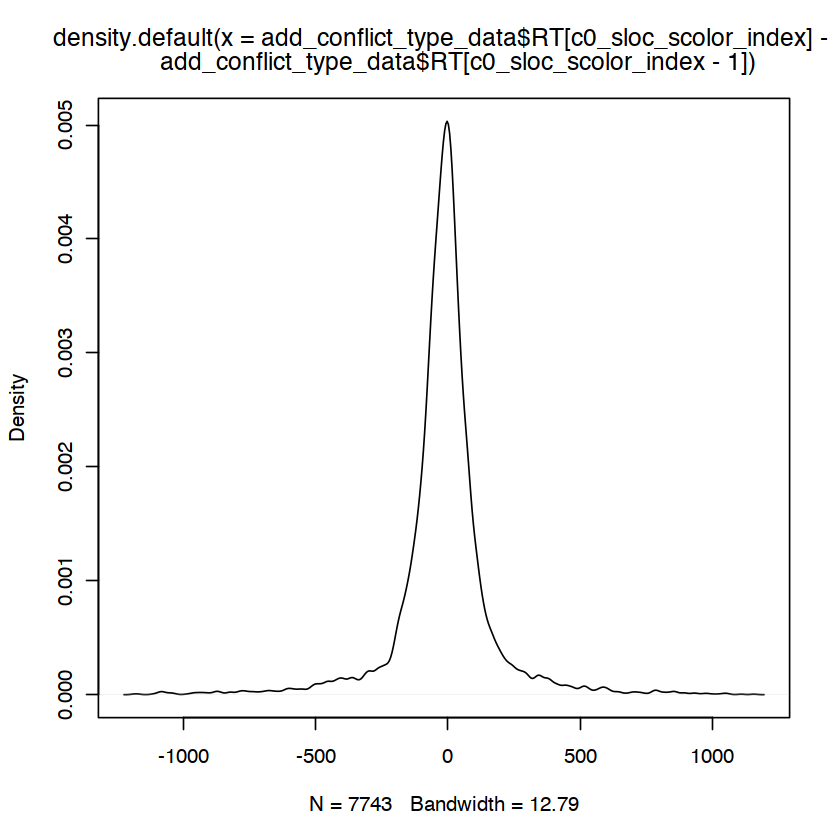

In [11]:
plot(density(add_conflict_type_data$RT[c0_sloc_scolor_index] - add_conflict_type_data$RT[c0_sloc_scolor_index - 1]))

正态性从图上看还是满足的. 那么接下来考虑样本量差异的问题. 我们选择使用置换检验来尝试解决这个问题.

In [12]:
library(coin)

Loading required package: survival



In [27]:
permute_two_type_trials_diffRT <- function(input_dataframe, index1, index2) {
    x_name <- paste0("mean_diff_", deparse(substitute(index1)))
    y_name <- paste0("mean_diff_", deparse(substitute(index2)))

    vector_1 <- input_dataframe[index1 - 1, ]$RT - input_dataframe[index1, ]$RT
    vector_2 <- input_dataframe[index2 - 1, ]$RT - input_dataframe[index2, ]$RT
    levels <- factor(c(rep("index1", length(vector_1)), rep("index2", length(vector_2))))
    test_data <- data.frame(value = c(vector_1, vector_2), levels)

    result <- coin::oneway_test(value~levels, test_data)

    return(result)
}

In [28]:
permute_two_type_trials_diffRT(
    add_conflict_type_data,
    c2_sloc_scolor_index, c1_sloc_scolor_index
)
permute_two_type_trials_diffRT(
    add_conflict_type_data,
    c2_sloc_scolor_index, c0_sloc_scolor_index
)
permute_two_type_trials_diffRT(
    add_conflict_type_data,
    c1_sloc_scolor_index, c0_sloc_scolor_index
)
permute_two_type_trials_diffRT(
    add_conflict_type_data,
    c0_sloc_scolor_index, c(c1_sloc_scolor_index, c2_sloc_scolor_index)
)
permute_two_type_trials_diffRT(
    add_conflict_type_data, 
    c2_sloc_scolor_index, c(c1_sloc_scolor_index, c0_sloc_scolor_index)
)


	Asymptotic Two-Sample Fisher-Pitman Permutation Test

data:  value by levels (index1, index2)
Z = 0.42438, p-value = 0.6713
alternative hypothesis: true mu is not equal to 0



	Asymptotic Two-Sample Fisher-Pitman Permutation Test

data:  value by levels (index1, index2)
Z = 1.5817, p-value = 0.1137
alternative hypothesis: true mu is not equal to 0



	Asymptotic Two-Sample Fisher-Pitman Permutation Test

data:  value by levels (index1, index2)
Z = 1.3995, p-value = 0.1617
alternative hypothesis: true mu is not equal to 0



	Asymptotic Two-Sample Fisher-Pitman Permutation Test

data:  value by levels (index1, index2)
Z = -1.9152, p-value = 0.05547
alternative hypothesis: true mu is not equal to 0



	Asymptotic Two-Sample Fisher-Pitman Permutation Test

data:  value by levels (index1, index2)
Z = 1.3781, p-value = 0.1682
alternative hypothesis: true mu is not equal to 0


从当前的结果来看, 明显是当冲突水平大于或小于0之间, 存在明显的行为差异. 考虑到老师的参数估计中没有考虑 threshold 为 0 的情况, 我们重新估计一下这种条件后的 MSE 结果. 并且可以看一下在冲突水平大于或小于 0 间, fMRI 的结果是否存在差异.